<img src="pics/arxiv_vs_snarxiv_logo.png" width=300>

# Can snarXiv-vs-arXiv be learned?

**Background**  
The [snarXiv-vs-arXiv](http://snarxiv.org/vs-arxiv/) website challenges you to tell fake physics research articles from real ones. Real paper titles are taken from [arXiv](https://arxiv.org/), fake titles are produced by a so-called context-free grammar. The snarXiv code is freely available ([link](https://github.com/davidsd/snarxiv)). 

**Aim**  
Develop a supervised learning algorithm to correctly classify arXiv vs. snarXiv titles.

**Method**  
- use selenium webdriver to scrape a number of titles from the website and parse the correct labels after clicking one of the titles; save this dataset for training/testing
- natural-language processing (NLP): transform the paper titles into a bag-of-words (BOW) model and vectorize
- train and optimize a classifier (scikit-learn)
- testing: apply the learned classifier to the snarXiv website

**Results**  
- classifiers reach around 90% accuracy on test data sets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from selenium import webdriver

## Download a training data set (*optional*)

This step is optional, the repo contains a training data set.   
The function below uses [Selenium](https://www.selenium.dev/documentation/) in order to: 
1. Scrape a number `2*n_total` of titles from http://snarxiv.org/vs-arxiv/
2. Clicks the left title and 
3. Parses the website's answer to get the correct label for that title.  

The results are stored in a Python dictionary (and optionally written to a file). You should get approximately `n_total` arXiv and `n_total` snarXiv samples.  

**Note**: Selenium needs the webdriver file. I get my Firefox geckodriver from https://github.com/mozilla/geckodriver/releases. More info at: https://github.com/mozilla/geckodriver


In [ ]:
def download(n_total=10, verbose=False):
    """
    Download 2n samples from: http://snarxiv.org/vs-arxiv"
    """
    options = webdriver.FirefoxOptions()
    options.add_argument("--headless")
    options.add_argument('--ignore-certificate-errors')
    options.add_argument("--test-type")
    profile = webdriver.FirefoxProfile()
    br = webdriver.Firefox(profile)
    br.get("http://snarxiv.org/vs-arxiv")

    n = 0 # counter
    n_correct = nc = 0 # current number of correct answers
    real_titles = []
    fake_titles = []
    while n <= n_total:
        if verbose: print(f"[+] Trial: {n:d}/{n_total:d}")
        # get DOM elements
        c0 = br.find_element_by_class_name('corner-0')
        h0 = c0.find_element_by_tag_name('h1')
        a0 = h0.find_element_by_tag_name('a')
        txt0 = a0.text.replace("Is this one real?", "") # left title
        c1 = br.find_element_by_class_name('corner-1')
        h1 = c1.find_element_by_tag_name('h1')
        a1 = h1.find_element_by_tag_name('a')
        txt1 = a1.text.replace("Is this one real?", "") # right title
        # always click left and parse true/false (arXiv/snarXiv) from the updated score
        a0.click()
        # number of correct guesses
        if n > 0:
            # DOM element indicating the current number of correct answers
            s_nc = br.find_element_by_id('correct').text
            try:
                nc = int(s_nc) # string => int
                if nc > n_correct:
                    # latest answer was correct
                    if verbose: print(f"\tcorrect (nc = {nc:d})")
                    n_correct = nc # update n_correct
                    real_titles.append(txt0) # left: correct
                    fake_titles.append(txt1) # right: wrong
                else:
                    # latest answer was not correct
                    if verbose: print(f"\twrong (nc = {nc:d})")
                    fake_titles.append(txt0) # left: wrong
                    real_titles.append(txt1) # right: correct
            except:
                # shouldn't occur, just skip and continue if it occurs
                print("error converting nc")
        n += 1
        time.sleep(1)  # wait a sec, just in case...
    #input("finished - quit?")
    br.quit()
    print("browser closed.")

    # review results
    if verbose:
        print("\n[+] Real titles")
        for i, title in enumerate(real_titles):
            print(f"\n#{i:d}\n{title:s}")
        print("\n[+] Fake titles")
        for i, title in enumerate(fake_titles):
            print(f"\n#{i:d}\n{title:s}")
    
    # save
    f_out = f"data/training_data.pkl"
    d = {'real' : real_titles, 'fake' : fake_titles}
    with open(f_out, "wb") as fp:
        pickle.dump(d, fp, pickle.HIGHEST_PROTOCOL)
    
    # for processing further down
    return real_titles, fake_titles

real, fake = download(n_total=10, verbose=False)

## Load standard training data set
If you haven't downloaded your own training data set, you can work with the standard training data set.

In [2]:
def reload(filename):
    """
    re-load and analyze samples
    """
    with open(filename, "rb") as fp:
        d = pickle.load(fp, encoding='latin1')
    real = d['real']
    fake = d['fake']
    print(f"Loaded n={len(real):d} real and n={len(fake):d} fake samples.")
    return real, fake

f_data = f"data/training_data_std.pkl"  # 1000 titles each
real, fake = reload(f_data)

Loaded n=1000 real and n=1000 fake samples.


## Examples
To better understand the problem, let's have a look at a few titles. Most people have difficulties deciding which titles stem from real papers and which were produced by the context-free grammar. 

In [3]:
print("Some real (arXiv) examples: \n" + 30*"=")
for i, r in enumerate(real[:5]): print(f"#{i:d}: {r.strip():s}", end="\n")
print("\nSome fake (snarXiv) examples: \n" + 30*"=")
for i, f in enumerate(fake[:5]): print(f"#{i:d}: {f.strip():s}", end="\n")

Some real (arXiv) examples: 
#0: Exact Effective Action for (1+1 Dimensional) Fermions in an Abelian Background at Finite Temperature
#1: Four Quark Cn - Nbar Cbar States in U(12)-Scheme and X(3872)/Y(3940)
#2: A Heavy Higgs and a Light Sneutrino NLSP in the MSSM With Enhanced SU(2) D-terms
#3: Exact Analytic Two-loop Expressions for Some QCD Observables in the Time-like Region
#4: Lattice Ising Model in a Field: E$_8$ Scattering Theory

Some fake (snarXiv) examples: 
#0: On Invertible QED_3
#1: Anomaly Matching in Deformed QFTs
#2: The Multi-field Solution to the LHC Inverse Problem From Inflaton Models (Including the Lithium Problem)
#3: The Holographic Entanglement of Purification of De Sitter Space in a Nonperturbative Nonperturbative Twisted QFT
#4: Models of Ghosts in Causality


## Text pre-processing
NLP algorithms usually pre-process text data. Common pre-processing steps involve:
- removal of punctuation (e.g.: ,.;!?)
- stemming (insert link)

Here, we will just apply a very basic pre-processing:
1. Strip trailing "\n" characters
2. Replace "blank-dash-blank" by "dash", e.g. "Quark Cn - Nbar Cbar States" => "Quark Cn-Nbar Cbar States"
3. Replace "blank-arrow-blank" by "arrow", e.g. "the B -> X_s Gamma Matrix" => "the B->X_s Gamma Matrix"
4. Convert all expressions to lowercase

Points 2. and 3. are necessary to avoid splitting expressions such as "Cn - Nbar" into ["Cn", "-", "Nbar"] when titles will be processed by the vectorizer. 

In [4]:
preprocess = lambda s: s.strip().replace(" - ", "-").replace(" -> ", "->").lower()

## Get a bag-of-words (bow) and target labels

In [5]:
def bow(real, fake):
    """
    Bag Of Words
    """
    all_titles = [preprocess(title) for title in real+fake]
    y = np.concatenate( (np.ones(len(real)), np.zeros(len(fake))) ) # target values (real: 1, fake: 0)
    return all_titles, y

titles, y = bow(real, fake)

## Train-test split
Do an 80-20 split on the data, retaining 20% for final performance evaluation.

In [6]:
from sklearn.model_selection import train_test_split #, StratifiedShuffleSplit
titles_train, titles_test, y_train, y_test = train_test_split(titles, y, test_size=0.2, random_state=1)

## Vectorizer transform
Next, the text data will be transformed to numbers, in order to work with numerical methods such as logistic regression, among others.  

**Options**:
- CountVectorizer
- TfidfVectorizer

**Note:** The vectorizer has to be trained on the *complete* data set. If the vectorizer is built on the training data set alone, some words in the testing data set may not be recognized.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(max_features=2000)
#vectorizer = TfidfVectorizer(max_features=2000)
vectorizer.fit(titles) # titles_train
print("Vocabulary size: ", len(vectorizer.vocabulary_), " words.")

Vocabulary size:  2000  words.


### Apply vectorizer to train and test data

In [8]:
X_train = vectorizer.transform(titles_train)
X_test = vectorizer.transform(titles_test)
print("Training and test data vectorized.", X_train.shape, X_test.shape)

Training and test data vectorized. (1600, 2000) (400, 2000)


**Side note:** What does the vectorizer do?

In [9]:
# count vectorizer
X = "this book is not my book".split()
vec2 = CountVectorizer().fit(X)
voc = vec2.vocabulary_
print("Vocabulary dict: ", voc) # <class 'dict'> 2358
Y = vec2.transform(X).toarray()
print("\nSentence transformed to array:\n", Y)
print("\nExplanation: ")
for i, x in enumerate(X):
    print(f"'{x:s}' encoded as a vector: ", Y[i,:], f" because voc['{x:s}'] = ", voc[x])
del X, Y

Vocabulary dict:  {'this': 4, 'book': 0, 'is': 1, 'not': 3, 'my': 2}

Sentence transformed to array:
 [[0 0 0 0 1]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]]

Explanation: 
'this' encoded as a vector:  [0 0 0 0 1]  because voc['this'] =  4
'book' encoded as a vector:  [1 0 0 0 0]  because voc['book'] =  0
'is' encoded as a vector:  [0 1 0 0 0]  because voc['is'] =  1
'not' encoded as a vector:  [0 0 0 1 0]  because voc['not'] =  3
'my' encoded as a vector:  [0 0 1 0 0]  because voc['my'] =  2
'book' encoded as a vector:  [1 0 0 0 0]  because voc['book'] =  0


## First ML approach: logistic regression

Data and target labels are prepared, time to train a classifier.

In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"{clf.__class__.__name__:s} accuracy: {score:.1%}")

save_vectorizer = False
if save_vectorizer:
    f_vect = "data/sklearn_snarxiv_vectorizer.pkl"
    with open(f_vect, 'wb') as fp:
        pickle.dump(vectorizer, fp)

save_classifier = False
if save_classifier:
    f_model = "data/sklearn_snarxiv_model.pkl"
    with open(f_model, 'wb') as fp:
        pickle.dump(clf, fp)

LogisticRegression accuracy: 90.0%


## Cross-validation
To test the robustness of this results, do a few runs of cross-validation.

In [11]:
from sklearn.model_selection import cross_val_score
n_cv = 5
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Scores: ", scores)
print(f"Mean score: {np.mean(scores):.2f}")

Scores:  [0.8625 0.8375 0.8375 0.8625 0.8125]
Mean score: 0.84


## Other classifiers
A few other scikit-learn classifiers to play with...

MLPClassifier accuracy: 92.0%


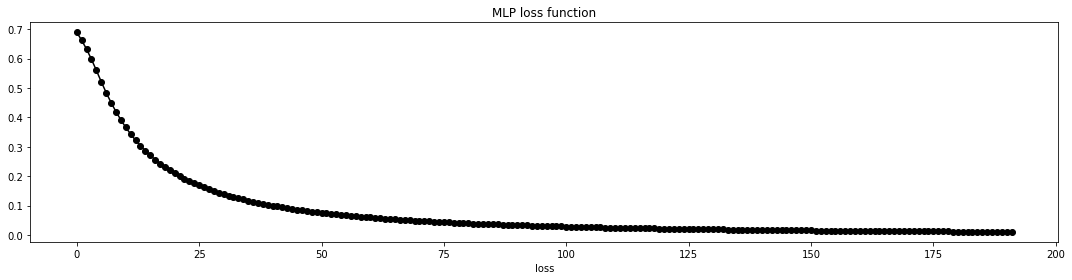

In [12]:
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(n_estimators=100) # 88.8%

#from sklearn.ensemble import GradientBoostingClassifier
#clf = GradientBoostingClassifier()

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(10,), alpha=1e-4, max_iter=300, random_state=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"{clf.__class__.__name__:s} accuracy: {score:.1%}")

plt.figure(figsize=(15,4))
plt.plot(clf.loss_curve_, '-ok')
plt.xlabel("iterations")
plt.xlabel("loss")
plt.title("MLP loss function")
plt.tight_layout()
plt.show()

## Grid search optimization of hyperparameters

Do a gridsearch to find optimum hyperparameter values, save the results.  
This code block can take a while to complete.

In [15]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(
    MLPClassifier(random_state=1, max_iter=300),
    param_grid={
        "hidden_layer_sizes": [10, 50, 100],
        "alpha": [0.0001, 0.001, 0.01],
    },
    return_train_score=True,
)
gs.fit(X_train, y_train)
#print(gs.cv_results_)
f_gs = "data/MLP_gridsearch_results.pkl"
with open(f_gs, 'wb') as fp: pickle.dump(gs.cv_results_, fp)

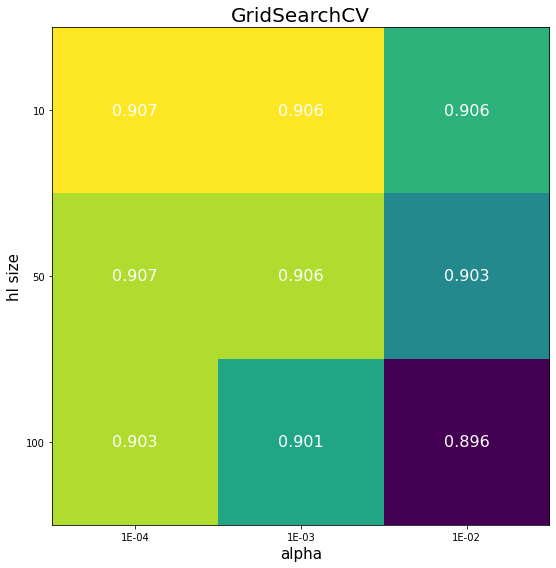

In [16]:
f_gs = "data/MLP_gridsearch_results.pkl"
with open(f_gs, "rb") as fp: mlp_gs = pickle.load(fp, encoding='latin1')
results = pd.DataFrame.from_dict(mlp_gs)
#print(results.head())
scores_matrix = results.pivot(
    index="param_hidden_layer_sizes", columns="param_alpha", values="mean_test_score"
)
#print(scores_matrix)

hl_sizes = [10, 50, 100]
alphas = [0.0001, 0.001, 0.01]

# heatmap adapted from: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.imshow(scores_matrix)
ax.set_xticks(np.arange(len(alphas)))
ax.set_xticklabels(["{:.0E}".format(x) for x in alphas])
ax.set_xlabel("alpha", fontsize=15)
ax.set_yticks(np.arange(len(hl_sizes)))
ax.set_yticklabels(["{:.0f}".format(x) for x in hl_sizes])
ax.set_ylabel("hl size", fontsize=15)
for i in range(len(alphas)):
    for j in range(len(hl_sizes)):
        t = f"{scores_matrix.loc[hl_sizes[j],alphas[i]]:.3f}"
        ax.text(j, i, t, ha="center", va="center", color="w", fontsize=16)
plt.title("GridSearchCV", fontsize=20)
plt.tight_layout()
plt.show()

## Test the classifier online

On our test data set, we got a pretty nice classification accuracy.  
It would be much nicer to see the classifier perform online, so let's do that. Again, we will use Selenium to interact with the [snarXiv-vs-arXiv](http://snarxiv.org/vs-arxiv/) website automatically.  
Sit back and enjoy the game!

In [ ]:
def apply_model(vectorizer=None, clf=None, n_total=1, verbose=False):
    if not vectorizer:
        # re-load vectorizer and model
        f_vect = "sklearn_snarxiv_vectorizer.pkl"
        with open(f_vect, 'rb') as fp:
            vectorizer = pickle.load(fp)

    if not clf:
        f_model = "sklearn_snarxiv_model.pkl"
        with open(f_model, 'rb') as fp:
            clf = pickle.load(fp)

    # connect to snarXiv
    options = webdriver.FirefoxOptions()
    options.add_argument("--headless")
    options.add_argument('--ignore-certificate-errors')
    options.add_argument("--test-type")
    profile = webdriver.FirefoxProfile()
    br = webdriver.Firefox(profile)
    br.get("http://snarxiv.org/vs-arxiv")

    #n_total = 1000 # number of trials
    n = 0 # counter
    n_correct = nc = 0 # current number of correct answers

    # collect titles for future training
    while n <= n_total:
        if verbose: print(f"[+] Trial: {n:d}/{n_total:d}")
        # get DOM elements
        c0 = br.find_element_by_class_name('corner-0')
        h0 = c0.find_element_by_tag_name('h1')
        a0 = h0.find_element_by_tag_name('a')
        txt0 = a0.text.replace("Is this one real?", "") # left title
        c1 = br.find_element_by_class_name('corner-1')
        h1 = c1.find_element_by_tag_name('h1')
        a1 = h1.find_element_by_tag_name('a')
        txt1 = a1.text.replace("Is this one real?", "") # right title
        # use the same preprocessing as during training
        txt0 = preprocess(txt0)
        txt1 = preprocess(txt1)
        # transform title
        x0 = vectorizer.transform([txt0])
        x1 = vectorizer.transform([txt1])
        # get classifier predictions
        pred0 = clf.predict(x0)
        pred1 = clf.predict(x1)
        #print("Predictions: ", pred0, pred1)
        # click the option with the higher classifier score
        if pred0 >= pred1:
            a0.click()
        else:
            a1.click()
        # number of correct guesses
        if n > 0:
            s_nc = br.find_element_by_id('correct').text
            try:
                nc = int(s_nc) # string => int
                if verbose: print(f"\tcorrect (nc = {nc:d})")
            except:
                if verbose: print("error converting nc")
        n += 1
        time.sleep(1)  # wait a sec, just in case...
    print(f"Classifier achieved {100.*nc/n:.1f}% accuracy online.")
    input("finished - quit?")
    br.quit()
    print("browser closed.")

In [ ]:
apply_model(vectorizer, clf, n_total=30, verbose=False)

### Proof of concept
Watch the classifier at work  
<br>
<video src="pics/snarxiv_MLPonline_test_crop.mp4" width=600 controls=true>

### Final note:
There is an easy way to get *all* answers right. The snarXiv-vs-arXiv web app sends a GET request to the `fight.py` server-side app. The response to this GET request contains the correct answer. As shown below, only the "Time-reversal..." title has a valid arXiv link (white arrow).

<img src="pics/network_screenshot2.png" width=1000 controls=true>